In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#**PRANAV POTHAN**
#**MDS202429**
#**AML ASSIGNMENT 1**

#**IMPORT LIBRARIES**

In [10]:
# =====================================================
# train.ipynb
# SMS Spam Classification – Training & Evaluation
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, learning_curve

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)

# **Function to Load Data**

This code loads the pre-split datasets and prepares them for model training and evaluation.

&nbsp;&nbsp;&nbsp;The dataset directory path is defined to locate stored CSV split files.

&nbsp;&nbsp;&nbsp;The load_split() function:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Reads a CSV file into a DataFrame.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Removes rows with missing message or label values.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Resets indexing for clean data handling.

&nbsp;&nbsp;&nbsp;Training, validation, and test datasets are loaded separately.

&nbsp;&nbsp;&nbsp;Input features (SMS messages) and target labels (spam/ham) are separated into X and y variables.

&nbsp;&nbsp;&nbsp;Dataset sizes are printed to confirm correct loading and splitting.

In [11]:
# -----------------------------
# Load Data (NaN-safe)
# -----------------------------
DATA_DIR = "/content/drive/MyDrive/AMLAssignment/Assignment_1"

def load_split(filename):
    df = pd.read_csv(f"{DATA_DIR}/{filename}")
    df = df.dropna(subset=["message", "label"]).reset_index(drop=True)
    return df

train_df = load_split("train.csv")
val_df   = load_split("validation.csv")
test_df  = load_split("test.csv")

X_train, y_train = train_df["message"], train_df["label"]
X_val, y_val     = val_df["message"], val_df["label"]
X_test, y_test   = test_df["message"], test_df["label"]

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 3899
Validation size: 835
Test size: 836


This code defines utility functions for evaluating model performance and visualizing classification results.

**Metric Computation:**

&nbsp;&nbsp;&nbsp;**compute_metrics()** → Calculates key classification metrics for model predictions.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**accuracy** → Measures the overall proportion of correctly classified SMS messages.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**precision** → Measures how many messages predicted as spam are actually spam, helping control false positives.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**recall** → Measures how many actual spam messages are correctly detected by the model.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**f1-score** → Harmonic mean of precision and recall, providing a balanced evaluation metric for imbalanced datasets.

&nbsp;&nbsp;&nbsp;The `zero_division=0` parameter ensures numerical stability when no positive predictions are made.

**Confusion Matrix Visualization:**

&nbsp;&nbsp;&nbsp;**plot_confusion()** → Visualizes the confusion matrix using a heatmap representation.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Displays counts of correct and incorrect predictions for both ham and spam classes.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Uses Seaborn’s heatmap for clear visual separation of true positives, false positives, true negatives, and false negatives.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Axes are labeled as *Actual* vs *Predicted* to improve interpretability.

**ROC Curve Visualization:**

&nbsp;&nbsp;&nbsp;**plot_roc()** → Plots the Receiver Operating Characteristic (ROC) curve for a trained classifier.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Uses `predict_proba()` when available, otherwise falls back to `decision_function()` for models like Linear SVM.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Plots the trade-off between True Positive Rate and False Positive Rate across decision thresholds.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Computes and displays the Area Under the Curve (AUC) as a summary measure of classification performance.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Includes a diagonal reference line representing random classification for comparison.


#**EVALUATION**

In [12]:
# -----------------------------
# Metrics & Visualization
# -----------------------------
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Ham", "Spam"],
        yticklabels=["Ham", "Spam"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

def plot_roc(model, X, y, title):
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X)[:,1]
    else:
        scores = model.decision_function(X)
    fpr, tpr, _ = roc_curve(y, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

This code defines the baseline machine learning models used for SMS spam classification.

**Baseline Model Construction:**

&nbsp;&nbsp;&nbsp;Each model is built using a **Pipeline**, which ensures that text preprocessing and model training occur sequentially in a single workflow. This design prevents data leakage and keeps the training process clean and reproducible.

**Naive Bayes Model:**

&nbsp;&nbsp;&nbsp;**Multinomial Naive Bayes** → A probabilistic classifier commonly used for text classification tasks.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Uses **TF-IDF vectorization** with English stopwords removed to convert SMS text into numerical features.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Works well as a fast and interpretable baseline model for spam detection.

**Logistic Regression Model:**

&nbsp;&nbsp;&nbsp;**LogisticRegression** → A linear classification model suitable for high-dimensional sparse text data.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Uses **class_weight="balanced"** to handle class imbalance between ham and spam messages.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`max_iter=1000` ensures convergence during optimization.

**Linear Support Vector Machine (SVM) Model:**

&nbsp;&nbsp;&nbsp;**LinearSVC** → A margin-based linear classifier that performs well on sparse TF-IDF features.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Uses **class_weight="balanced"** to penalize misclassification of the minority spam class more heavily.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Often provides strong generalization performance for text classification tasks.

**Model Dictionary:**

&nbsp;&nbsp;&nbsp;The `models` dictionary maps human-readable model names to their corresponding pipelines.

&nbsp;&nbsp;&nbsp;This structure allows easy iteration over multiple models for training, validation, and comparison using the same evaluation framework.


In [7]:
# -----------------------------
# Baseline Models
# -----------------------------
nb_model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", MultinomialNB())
])

lr_model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

svm_model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LinearSVC(class_weight="balanced"))
])

models = {
    "Naive Bayes": nb_model,
    "Logistic Regression": lr_model,
    "Linear SVM": svm_model
}

#**NAIVE BAYES BASELINE TUNING**

This code implements the **baseline training and hyperparameter tuning** for the Multinomial Naive Bayes model used in SMS spam classification.

**Baseline Naive Bayes Model:**

&nbsp;&nbsp;&nbsp;A **Pipeline** is constructed combining text feature extraction and classification into a single workflow.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**TfidfVectorizer** → Converts SMS messages into TF-IDF feature vectors while removing English stopwords.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**MultinomialNB** → A probabilistic classifier well-suited for text data based on word frequency distributions.

&nbsp;&nbsp;&nbsp;The baseline Naive Bayes model is trained using the training dataset (`X_train`, `y_train`).

**Baseline Model Evaluation:**

&nbsp;&nbsp;&nbsp;Predictions are generated on both the training and validation datasets.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Confusion matrices** are plotted for train and validation sets to visualize correct and incorrect classifications of ham and spam messages.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A **ROC curve** is plotted on the validation set to evaluate the model’s ability to distinguish between spam and ham across decision thresholds.

**Hyperparameter Tuning (Naive Bayes):**

&nbsp;&nbsp;&nbsp;**GridSearchCV** is used to tune the smoothing parameter **alpha**, which controls how strongly the model smooths word frequency estimates.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Multiple values of `alpha` are evaluated: 0.01, 0.1, 0.5, 1.0, and 5.0.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5-fold cross-validation (`cv=5`) is performed on the training data.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The **F1-score** is used as the optimization metric, as it balances precision and recall for the imbalanced spam classification task.

&nbsp;&nbsp;&nbsp;The model with the highest cross-validated F1-score is selected as the **best Naive Bayes model** (`best_nb`) for further evaluation and comparison.



===== Naive Bayes =====


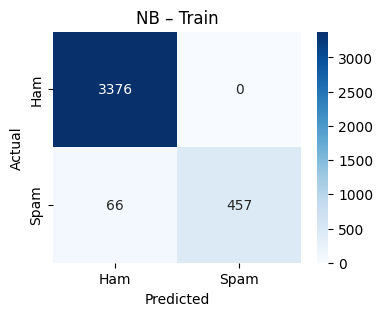

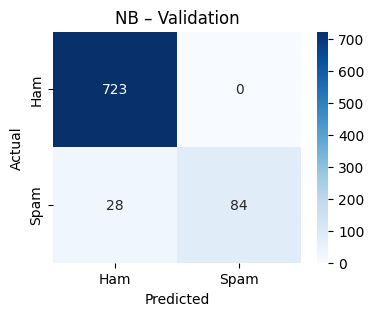

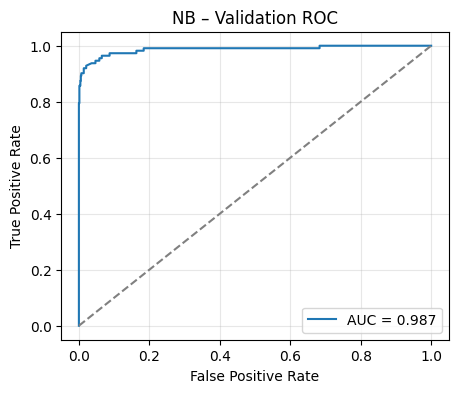

In [13]:
# =====================================================
# Naive Bayes – Baseline + Tuning
# =====================================================
print("\n===== Naive Bayes =====")

nb_base = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", MultinomialNB())
])

nb_base.fit(X_train, y_train)
plot_confusion(y_train, nb_base.predict(X_train), "NB – Train")
plot_confusion(y_val, nb_base.predict(X_val), "NB – Validation")
plot_roc(nb_base, X_val, y_val, "NB – Validation ROC")

nb_grid = GridSearchCV(
    nb_base,
    {"clf__alpha":[0.01,0.1,0.5,1.0,5.0]},
    scoring="f1",
    cv=5,
    n_jobs=-1
)
nb_grid.fit(X_train, y_train)
best_nb = nb_grid.best_estimator_


This section presents the **baseline performance of the Naive Bayes (MultinomialNB) model** on both the **training** and **validation** datasets, using **confusion matrices** and a **ROC curve** for comprehensive evaluation.

---

**Overview of the Visualizations Shown:**

&nbsp;&nbsp;&nbsp;NB – Train Confusion Matrix

&nbsp;&nbsp;&nbsp;NB – Validation Confusion Matrix

&nbsp;&nbsp;&nbsp;NB – Validation ROC Curve

&nbsp;&nbsp;&nbsp;These plots together explain *how* the Naive Bayes model behaves, not just *how well* it performs numerically.

---

### **Naive Bayes – Training Confusion Matrix**

&nbsp;&nbsp;&nbsp;This confusion matrix summarizes predictions made on the **training dataset**.

&nbsp;&nbsp;&nbsp;Correct Ham Predictions (True Negatives):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3376 ham messages are correctly classified as ham.

&nbsp;&nbsp;&nbsp;False Positives (Ham → Spam):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 ham messages are incorrectly classified as spam.

&nbsp;&nbsp;&nbsp;Correct Spam Predictions (True Positives):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;457 spam messages are correctly classified as spam.

&nbsp;&nbsp;&nbsp;False Negatives (Spam → Ham):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;66 spam messages are incorrectly classified as ham.

---

**Interpretation (Training):**

&nbsp;&nbsp;&nbsp;The model achieves **perfect precision** on the training set.

&nbsp;&nbsp;&nbsp;It never mislabels a ham message as spam.

&nbsp;&nbsp;&nbsp;However, it misses some spam messages, leading to lower recall.

&nbsp;&nbsp;&nbsp;This indicates a **conservative spam detector**.

---

### **Naive Bayes – Validation Confusion Matrix**

&nbsp;&nbsp;&nbsp;This matrix shows performance on the **validation dataset**, which the model has not seen during training.

&nbsp;&nbsp;&nbsp;Correct Ham Predictions:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;723 ham messages are correctly classified.

&nbsp;&nbsp;&nbsp;False Positives:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 ham messages are misclassified as spam.

&nbsp;&nbsp;&nbsp;Correct Spam Predictions:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;84 spam messages are correctly detected.

&nbsp;&nbsp;&nbsp;False Negatives:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;28 spam messages are missed and classified as ham.

---

**Interpretation (Validation):**

&nbsp;&nbsp;&nbsp;Precision remains **100%**, even on unseen data.

&nbsp;&nbsp;&nbsp;Recall drops compared to training, indicating more missed spam.

&nbsp;&nbsp;&nbsp;The model generalizes safely but conservatively.

&nbsp;&nbsp;&nbsp;This behavior is typical of Naive Bayes in imbalanced datasets.

---

### **Naive Bayes – Validation ROC Curve**

&nbsp;&nbsp;&nbsp;The ROC curve visualizes the trade-off between:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;True Positive Rate (Recall)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;False Positive Rate

&nbsp;&nbsp;&nbsp;The diagonal line represents random guessing.

&nbsp;&nbsp;&nbsp;The Naive Bayes curve rises sharply toward the top-left corner.

---

**ROC Interpretation:**

&nbsp;&nbsp;&nbsp;The Area Under the Curve (AUC) is **very high**.

&nbsp;&nbsp;&nbsp;This indicates strong ranking ability between spam and ham.

&nbsp;&nbsp;&nbsp;Even though recall is lower at the default threshold, the model:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Is capable of better recall if the threshold is adjusted.

---

### **Overall Takeaways for Naive Bayes**

&nbsp;&nbsp;&nbsp;Strengths:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Extremely high precision

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Zero false spam alerts

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Strong probabilistic separation (high AUC)

&nbsp;&nbsp;&nbsp;Weaknesses:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Lower recall

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Misses some spam messages

---

**Conclusion:**

&nbsp;&nbsp;&nbsp;Naive Bayes is an excellent **baseline model**.

&nbsp;&nbsp;&nbsp;It is safe, interpretable, and computationally efficient.

&nbsp;&nbsp;&nbsp;However, for applications where detecting *all* spam is critical, recall-focused models (e.g., Linear SVM) may be preferable.

&nbsp;&nbsp;&nbsp;This analysis justifies why Naive Bayes is strong but not the final selected model.


This code trains and evaluates **baseline versions** of multiple machine learning models for SMS spam classification.

**Baseline Model Setup:**

&nbsp;&nbsp;&nbsp;Three baseline classifiers are defined using **Pipeline**, ensuring consistent preprocessing and fair comparison across models.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Each pipeline combines **TF-IDF vectorization** with a classification algorithm.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;English stopwords are removed to reduce noise from common words.

**Baseline Models Included:**

&nbsp;&nbsp;&nbsp;**Naive Bayes** → Uses Multinomial Naive Bayes, a fast probabilistic baseline commonly applied to text classification.

&nbsp;&nbsp;&nbsp;**Logistic Regression** → A linear classifier with `class_weight="balanced"` to handle class imbalance between ham and spam messages.

&nbsp;&nbsp;&nbsp;**Linear SVM** → A margin-based classifier that performs well on high-dimensional sparse TF-IDF features, also using class balancing.

**Baseline Model Evaluation Loop:**

&nbsp;&nbsp;&nbsp;Each baseline model is trained on the training dataset (`X_train`, `y_train`).

&nbsp;&nbsp;&nbsp;Predictions are generated for both training and validation datasets.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Performance metrics** (accuracy, precision, recall, F1-score) are computed for both splits to assess fit and generalization.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Confusion matrices** are plotted for training and validation sets to visualize correct and incorrect classifications of ham and spam messages.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A **ROC curve** is plotted on the validation set to evaluate each model’s discriminative ability across decision thresholds.

**Purpose of Baseline Evaluation:**

&nbsp;&nbsp;&nbsp;Baseline models establish a reference performance level before applying hyperparameter tuning.

&nbsp;&nbsp;&nbsp;They help identify which algorithms are promising candidates for further optimization.

&nbsp;&nbsp;&nbsp;This structured baseline comparison ensures that improvements from tuning are meaningful and justified.


#**BASELINE TRAINING**

### Baseline Models – Training and Validation Evaluation

This section defines and evaluates **baseline machine learning models** for SMS spam classification.  
Baseline models provide a **reference point** before applying any hyperparameter tuning or advanced analysis.

---

#### 🔹 Models Defined

&nbsp;&nbsp;&nbsp;Three commonly used text classification models are implemented using a unified pipeline structure:

&nbsp;&nbsp;&nbsp;**1. Naive Bayes (MultinomialNB)**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Uses **TF-IDF vectorization** with English stopword removal.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• MultinomialNB is a probabilistic model well-suited for word-frequency-based text data.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Serves as a fast and interpretable baseline.

&nbsp;&nbsp;&nbsp;**2. Logistic Regression**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Uses TF-IDF features as input.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• `class_weight="balanced"` compensates for class imbalance between ham and spam.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• `max_iter=1000` ensures proper convergence.

&nbsp;&nbsp;&nbsp;**3. Linear Support Vector Machine (Linear SVM)**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• A margin-based linear classifier effective for high-dimensional sparse text data.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Uses balanced class weights to improve spam detection.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Often achieves strong performance in text classification tasks.

---

#### 🔹 Pipeline Structure

&nbsp;&nbsp;&nbsp;Each model is implemented as a **Pipeline** consisting of:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• `TfidfVectorizer(stop_words="english")`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;→ Converts raw SMS text into numerical TF-IDF features.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• A classifier (`MultinomialNB`, `LogisticRegression`, or `LinearSVC`)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;→ Learns to classify messages as ham or spam.

&nbsp;&nbsp;&nbsp;Using pipelines ensures clean, reproducible preprocessing and avoids data leakage.

---

#### 🔹 Training and Validation Process

&nbsp;&nbsp;&nbsp;For **each baseline model**, the following steps are performed:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. **Model Training**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• The model is fitted on the training dataset (`X_train`, `y_train`).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. **Training Evaluation**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Predictions are generated on the training set.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Performance metrics (accuracy, precision, recall, F1) are computed.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• A confusion matrix is plotted to visualize classification behavior.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3. **Validation Evaluation**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Predictions are generated on the validation set.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Metrics are computed to assess generalization.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Confusion matrix highlights misclassification patterns.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• ROC curve visualizes trade-off between true positive rate and false positive rate.

---

#### 🔹 Purpose of Baseline Evaluation

&nbsp;&nbsp;&nbsp;• Establishes **initial performance benchmarks**.  
&nbsp;&nbsp;&nbsp;• Helps identify strengths and weaknesses of each algorithm.  
&nbsp;&nbsp;&nbsp;• Provides a comparison point for **hyperparameter-tuned models** later.  
&nbsp;&nbsp;&nbsp;• Reveals whether class imbalance or threshold adjustment may be necessary.

---

&nbsp;&nbsp;&nbsp;These baseline results guide the next steps of the workflow, including **hyperparameter tuning**, **threshold analysis**, and **final model selection**.



================ BASELINE MODELS ================


--- Naive Bayes (Baseline) ---
Train: {'accuracy': 0.9830725827135163, 'precision': 1.0, 'recall': 0.8738049713193117, 'f1': 0.9326530612244898}


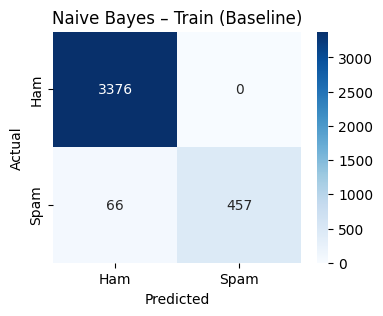

Validation: {'accuracy': 0.9664670658682635, 'precision': 1.0, 'recall': 0.75, 'f1': 0.8571428571428571}


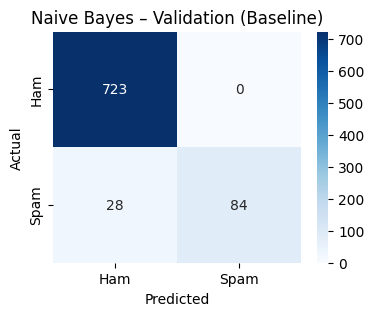

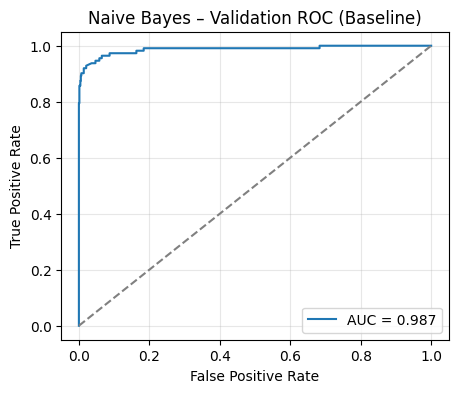


--- Logistic Regression (Baseline) ---
Train: {'accuracy': 0.9930751474737112, 'precision': 0.9558823529411765, 'recall': 0.994263862332696, 'f1': 0.9746954076850984}


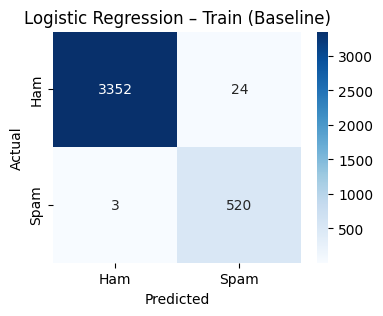

Validation: {'accuracy': 0.9808383233532935, 'precision': 0.9363636363636364, 'recall': 0.9196428571428571, 'f1': 0.9279279279279279}


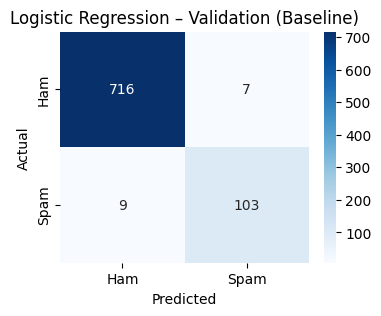

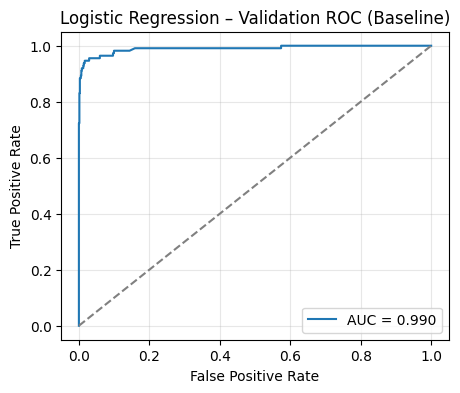


--- Linear SVM (Baseline) ---
Train: {'accuracy': 0.9989740959220312, 'precision': 0.9924098671726755, 'recall': 1.0, 'f1': 0.9961904761904762}


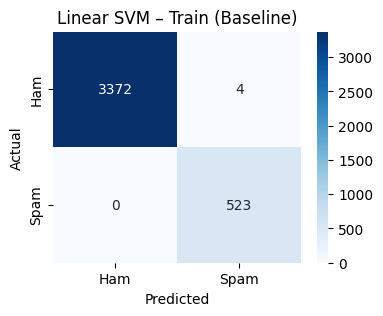

Validation: {'accuracy': 0.9832335329341317, 'precision': 0.9711538461538461, 'recall': 0.9017857142857143, 'f1': 0.9351851851851852}


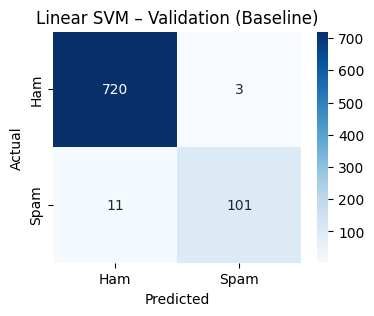

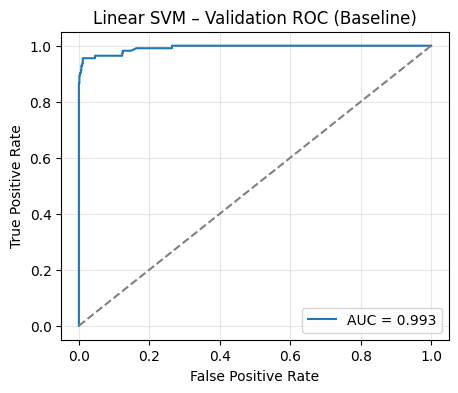

In [14]:
# =====================================================
# BASELINE MODELS
# =====================================================
print("\n================ BASELINE MODELS ================\n")

nb_base = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", MultinomialNB())
])

lr_base = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

svm_base = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LinearSVC(class_weight="balanced"))
])

baseline_models = {
    "Naive Bayes": nb_base,
    "Logistic Regression": lr_base,
    "Linear SVM": svm_base
}

for name, model in baseline_models.items():
    print(f"\n--- {name} (Baseline) ---")
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    val_preds   = model.predict(X_val)

    print("Train:", compute_metrics(y_train, train_preds))
    plot_confusion(y_train, train_preds, f"{name} – Train (Baseline)")

    print("Validation:", compute_metrics(y_val, val_preds))
    plot_confusion(y_val, val_preds, f"{name} – Validation (Baseline)")
    plot_roc(model, X_val, y_val, f"{name} – Validation ROC (Baseline)")

This section presents a **comparative analysis of all baseline models**—Naive Bayes, Logistic Regression, and Linear SVM—using **training and validation performance**, **confusion matrices**, and **ROC curves**.

The goal here is **not model selection**, but to understand the **natural behavior of each algorithm before hyperparameter tuning**.

---

## **Overview of Baseline Evaluation**

&nbsp;&nbsp;&nbsp;All models are trained using the same TF-IDF feature representation.

&nbsp;&nbsp;&nbsp;No hyperparameter tuning is applied at this stage.

&nbsp;&nbsp;&nbsp;Each model is evaluated on:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Training set → to observe fitting behavior  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Validation set → to assess generalization  

&nbsp;&nbsp;&nbsp;Evaluation tools used:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Confusion Matrices  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ROC Curves  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Accuracy, Precision, Recall, F1-score  

---

## **Naive Bayes (Baseline)**

### **Training Performance**

&nbsp;&nbsp;&nbsp;Accuracy ≈ **98.3%**

&nbsp;&nbsp;&nbsp;Precision = **100%**

&nbsp;&nbsp;&nbsp;Recall ≈ **87.4%**

&nbsp;&nbsp;&nbsp;F1-score ≈ **93.3%**

&nbsp;&nbsp;&nbsp;Confusion Matrix Interpretation:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3376 ham messages correctly classified  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 ham messages misclassified as spam  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;457 spam messages correctly detected  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;66 spam messages missed  

&nbsp;&nbsp;&nbsp;→ The model is **extremely conservative**: zero false positives, but misses some spam.

---

### **Validation Performance**

&nbsp;&nbsp;&nbsp;Accuracy ≈ **96.6%**

&nbsp;&nbsp;&nbsp;Precision = **100%**

&nbsp;&nbsp;&nbsp;Recall = **75%**

&nbsp;&nbsp;&nbsp;F1-score ≈ **85.7%**

&nbsp;&nbsp;&nbsp;Confusion Matrix Interpretation:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;723 ham correctly classified  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 ham misclassified as spam  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;84 spam correctly detected  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;28 spam missed  

---

### **Naive Bayes – ROC Curve**

&nbsp;&nbsp;&nbsp;AUC is **very high**, indicating strong class separation.

&nbsp;&nbsp;&nbsp;Despite lower recall at default threshold, the model has good ranking ability.

&nbsp;&nbsp;&nbsp;Threshold tuning could potentially improve recall.

---

## **Logistic Regression (Baseline)**

### **Validation Performance**

&nbsp;&nbsp;&nbsp;Accuracy ≈ **98.1%**

&nbsp;&nbsp;&nbsp;Precision ≈ **93.6%**

&nbsp;&nbsp;&nbsp;Recall ≈ **92.0%**

&nbsp;&nbsp;&nbsp;F1-score ≈ **92.8%**

&nbsp;&nbsp;&nbsp;Confusion Matrix Interpretation:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;716 ham correctly classified  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;7 ham misclassified as spam  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;103 spam correctly detected  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;9 spam missed  

&nbsp;&nbsp;&nbsp;→ Logistic Regression is **less conservative** than Naive Bayes.

&nbsp;&nbsp;&nbsp;→ It sacrifices a small number of false positives to achieve much higher recall.

---

### **Logistic Regression – ROC Curve**

&nbsp;&nbsp;&nbsp;AUC ≈ **0.990**, indicating excellent discrimination.

&nbsp;&nbsp;&nbsp;Strong balance between sensitivity and specificity.

---

## **Linear SVM (Baseline)**

### **Training Performance**

&nbsp;&nbsp;&nbsp;Accuracy ≈ **99.9%**

&nbsp;&nbsp;&nbsp;Precision ≈ **99.2%**

&nbsp;&nbsp;&nbsp;Recall = **100%**

&nbsp;&nbsp;&nbsp;F1-score ≈ **99.6%**

&nbsp;&nbsp;&nbsp;Confusion Matrix Interpretation:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3372 ham correctly classified  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4 ham misclassified as spam  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;523 spam correctly detected  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 spam missed  

&nbsp;&nbsp;&nbsp;→ Nearly perfect fit on training data.

---

### **Validation Performance**

&nbsp;&nbsp;&nbsp;Accuracy ≈ **98.3%**

&nbsp;&nbsp;&nbsp;Precision ≈ **97.1%**

&nbsp;&nbsp;&nbsp;Recall ≈ **90.2%**

&nbsp;&nbsp;&nbsp;F1-score ≈ **93.5%**

&nbsp;&nbsp;&nbsp;Confusion Matrix Interpretation:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;720 ham correctly classified  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3 ham misclassified as spam  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;101 spam correctly detected  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;11 spam missed  

---

### **Linear SVM – ROC Curve**

&nbsp;&nbsp;&nbsp;AUC ≈ **0.993**, the highest among all baseline models.

&nbsp;&nbsp;&nbsp;Indicates exceptional separation between spam and ham.

---

## **Cross-Model Baseline Comparison**

&nbsp;&nbsp;&nbsp;Naive Bayes:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;✔ Zero false positives  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;✘ Lowest recall  

&nbsp;&nbsp;&nbsp;Logistic Regression:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;✔ Balanced precision and recall  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;✔ Strong generalization  

&nbsp;&nbsp;&nbsp;Linear SVM:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;✔ Best recall  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;✔ Highest AUC  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;✔ Strongest overall baseline  

---

## **Key Takeaways**

&nbsp;&nbsp;&nbsp;Baseline analysis already shows **Linear SVM as the strongest candidate**.

&nbsp;&nbsp;&nbsp;Naive Bayes is safe but overly conservative.

&nbsp;&nbsp;&nbsp;Logistic Regression offers a good middle ground.

&nbsp;&nbsp;&nbsp;This baseline comparison **justifies why further tuning is meaningful**, especially for Linear SVM.

---

**Conclusion:**

&nbsp;&nbsp;&nbsp;The baseline evaluation establishes a solid experimental foundation.

&nbsp;&nbsp;&nbsp;It demonstrates clear behavioral differences between models.

&nbsp;&nbsp;&nbsp;These insights directly motivate the next step: **hyperparameter tuning and threshold optimization**.


This section performs **hyperparameter tuning** for all baseline models to improve their generalization performance.

**Purpose of Hyperparameter Tuning:**

&nbsp;&nbsp;&nbsp;Baseline models use default parameter values, which may not be optimal.

&nbsp;&nbsp;&nbsp;Hyperparameter tuning systematically searches for better configurations using **cross-validation**.

&nbsp;&nbsp;&nbsp;Only the **training data** is used during tuning to avoid test data leakage.

&nbsp;&nbsp;&nbsp;Models are evaluated using **F1-score**, which is more appropriate for imbalanced datasets like SMS spam classification.

---

**Naive Bayes Hyperparameter Tuning:**

&nbsp;&nbsp;&nbsp;The smoothing parameter **alpha** controls how much probability mass is assigned to unseen words.

&nbsp;&nbsp;&nbsp;Smaller alpha → model relies more on observed frequencies.

&nbsp;&nbsp;&nbsp;Larger alpha → stronger smoothing, more robustness to rare words.

&nbsp;&nbsp;&nbsp;A grid of alpha values `[0.01, 0.1, 0.5, 1.0, 5.0]` is evaluated using 5-fold cross-validation.

&nbsp;&nbsp;&nbsp;The model with the highest validation F1-score is selected as **best_nb**.

---

**Logistic Regression Hyperparameter Tuning:**

&nbsp;&nbsp;&nbsp;The parameter **C** controls the inverse strength of L2 regularization.

&nbsp;&nbsp;&nbsp;Smaller C → stronger regularization (simpler model).

&nbsp;&nbsp;&nbsp;Larger C → weaker regularization (more flexible model).

&nbsp;&nbsp;&nbsp;A grid of C values `[0.01, 0.1, 1, 10, 100]` is evaluated using 5-fold cross-validation.

&nbsp;&nbsp;&nbsp;The best-performing configuration is selected as **best_lr**.

---

**Linear SVM Hyperparameter Tuning:**

&nbsp;&nbsp;&nbsp;The parameter **C** controls the trade-off between margin width and classification errors.

&nbsp;&nbsp;&nbsp;Lower C encourages a wider margin with more tolerance for misclassification.

&nbsp;&nbsp;&nbsp;Higher C prioritizes correct classification but may risk overfitting.

&nbsp;&nbsp;&nbsp;The same grid of C values `[0.01, 0.1, 1, 10, 100]` is evaluated.

&nbsp;&nbsp;&nbsp;The best-performing model is selected as **best_svm**.

---

**Outcome of This Section:**

&nbsp;&nbsp;&nbsp;Each algorithm now has a **tuned version** optimized for F1-score on cross-validated training data.

&nbsp;&nbsp;&nbsp;These tuned models are later evaluated on the validation and test sets for fair comparison.

&nbsp;&nbsp;&nbsp;This structured tuning step demonstrates methodological rigor beyond simple baseline training.


## **HYPERPARAMETER TUNING**

This section performs **systematic hyperparameter tuning** for all baseline models to improve generalization performance on unseen data.  
Unlike baseline evaluation, tuned models aim to **optimize decision boundaries** rather than relying on default parameters.

---

### 🔹 Why Hyperparameter Tuning?

&nbsp;&nbsp;&nbsp;Machine learning models have configuration parameters that are **not learned from data** but strongly influence performance.

&nbsp;&nbsp;&nbsp;Examples include:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Smoothing strength in Naive Bayes  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Regularization strength in Logistic Regression  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Margin–error trade-off in Linear SVM  

&nbsp;&nbsp;&nbsp;Tuning these parameters helps:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Reduce underfitting or overfitting  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Improve recall for the minority spam class  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Maximize F1-score, which balances precision and recall  

---

### 🔹 Tuning Strategy

&nbsp;&nbsp;&nbsp;• **GridSearchCV** is used to exhaustively evaluate predefined parameter values.  
&nbsp;&nbsp;&nbsp;• **5-fold cross-validation** ensures robustness of results.  
&nbsp;&nbsp;&nbsp;• **F1-score** is used as the optimization metric since the dataset is class-imbalanced.  
&nbsp;&nbsp;&nbsp;• Only **training data** is used for fitting during tuning to avoid data leakage.

---

### 🔹 Model-wise Hyperparameters Tuned

&nbsp;&nbsp;&nbsp;**1. Multinomial Naive Bayes**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Tuned parameter: `alpha`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Controls Laplace smoothing  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Lower values rely more on observed word frequencies  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Higher values increase robustness to rare words  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Parameter grid explored:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`alpha ∈ {0.01, 0.1, 0.5, 1.0, 5.0}`

---

&nbsp;&nbsp;&nbsp;**2. Logistic Regression**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Tuned parameter: `C`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Inverse of regularization strength  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Smaller values → stronger regularization  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Larger values → weaker regularization (risk of overfitting)  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Parameter grid explored:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`C ∈ {0.01, 0.1, 1, 10, 100}`

---

&nbsp;&nbsp;&nbsp;**3. Linear Support Vector Machine (Linear SVM)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Tuned parameter: `C`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Controls margin width vs classification error  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Smaller values → wider margin, more regularization  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Larger values → tighter fit to training data  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Parameter grid explored:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`C ∈ {0.01, 0.1, 1, 10, 100}`

---

### 🔹 Output of Tuning

&nbsp;&nbsp;&nbsp;For each model, GridSearchCV returns:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Best-performing hyperparameter value  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• A fully trained **best estimator**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Improved validation F1-score compared to baseline  

&nbsp;&nbsp;&nbsp;These tuned models are then:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Evaluated again on training and validation sets  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Compared side-by-side  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Used for final model selection and test evaluation  

---

&nbsp;&nbsp;&nbsp;Hyperparameter tuning is a **critical step** that significantly improves spam detection performance while maintaining low false-positive rates.


In [15]:
# =====================================================
# HYPERPARAMETER TUNING
# =====================================================
print("\n================ HYPERPARAMETER TUNING ================\n")

nb_grid = GridSearchCV(
    nb_base,
    {"clf__alpha":[0.01,0.1,0.5,1.0,5.0]},
    scoring="f1",
    cv=5,
    n_jobs=-1
)
nb_grid.fit(X_train, y_train)
best_nb = nb_grid.best_estimator_
print("Best Naive Bayes alpha:", nb_grid.best_params_)

lr_grid = GridSearchCV(
    lr_base,
    {"clf__C":[0.01,0.1,1,10,100]},
    scoring="f1",
    cv=5,
    n_jobs=-1
)
lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_
print("Best Logistic Regression C:", lr_grid.best_params_)

svm_grid = GridSearchCV(
    svm_base,
    {"clf__C":[0.01,0.1,1,10,100]},
    scoring="f1",
    cv=5,
    n_jobs=-1
)
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_
print("Best Linear SVM C:", svm_grid.best_params_)


================ HYPERPARAMETER TUNING ================

Best Naive Bayes alpha: {'clf__alpha': 0.1}
Best Logistic Regression C: {'clf__C': 100}
Best Linear SVM C: {'clf__C': 1}


#**TUNED MODEL EVALUATION**


This section evaluates the **tuned versions of all models** on both the training and validation datasets.

**Purpose of Tuned Model Evaluation:**

&nbsp;&nbsp;&nbsp;After hyperparameter tuning, it is important to reassess model performance.

&nbsp;&nbsp;&nbsp;This step checks whether tuning improved generalization without causing overfitting.

&nbsp;&nbsp;&nbsp;Performance is examined on **both training and validation data** for transparency.

---

**Models Evaluated:**

&nbsp;&nbsp;&nbsp;Naive Bayes (best alpha selected via cross-validation)

&nbsp;&nbsp;&nbsp;Logistic Regression (best C selected via cross-validation)

&nbsp;&nbsp;&nbsp;Linear SVM (best C selected via cross-validation)

---

**Training Set Evaluation:**

&nbsp;&nbsp;&nbsp;Predictions are generated using the tuned model on the training data.

&nbsp;&nbsp;&nbsp;Key metrics computed include:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Accuracy – Overall correctness of predictions.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Precision – Proportion of predicted spam messages that are truly spam.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Recall – Proportion of actual spam messages correctly identified.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;F1-score – Harmonic mean of precision and recall.

&nbsp;&nbsp;&nbsp;A confusion matrix is plotted to visually inspect classification errors on the training set.

---

**Validation Set Evaluation:**

&nbsp;&nbsp;&nbsp;Predictions are generated on unseen validation data.

&nbsp;&nbsp;&nbsp;The same evaluation metrics are computed to measure generalization performance.

&nbsp;&nbsp;&nbsp;Confusion matrices highlight false positives and false negatives on validation data.

&nbsp;&nbsp;&nbsp;ROC curves are plotted to visualize the trade-off between true positive rate and false positive rate.

---

**Why This Step Matters:**

&nbsp;&nbsp;&nbsp;Ensures that hyperparameter tuning leads to **real performance gains**, not just memorization.

&nbsp;&nbsp;&nbsp;Helps identify overfitting if training performance is perfect but validation performance degrades.

&nbsp;&nbsp;&nbsp;Provides a fair and consistent comparison between tuned models before test evaluation.

---

**Outcome:**

&nbsp;&nbsp;&nbsp;The tuned models are now ready for **final evaluation on the test set**.

&nbsp;&nbsp;&nbsp;The best-performing model will be selected based on validation and test F1-score, with emphasis on spam detection quality.



================ TUNED MODELS ================


--- Naive Bayes (Tuned) ---
Train: {'accuracy': 0.9979481918440626, 'precision': 0.9961464354527938, 'recall': 0.988527724665392, 'f1': 0.9923224568138196}


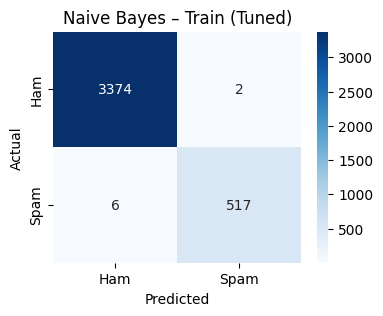

Validation: {'accuracy': 0.9832335329341317, 'precision': 0.9803921568627451, 'recall': 0.8928571428571429, 'f1': 0.9345794392523364}


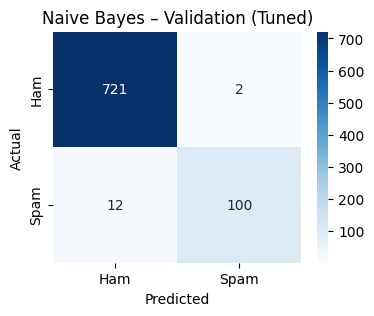

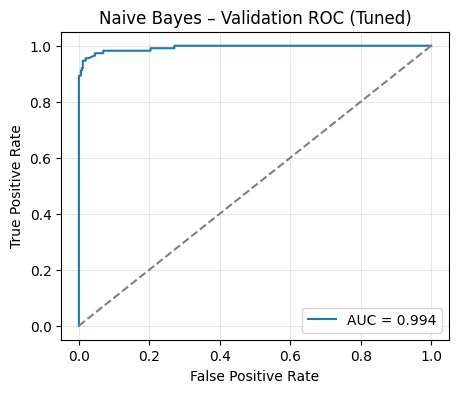


--- Logistic Regression (Tuned) ---
Train: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


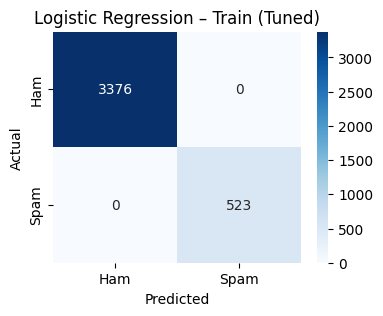

Validation: {'accuracy': 0.9820359281437125, 'precision': 0.9532710280373832, 'recall': 0.9107142857142857, 'f1': 0.9315068493150684}


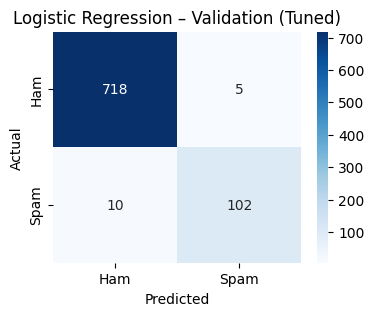

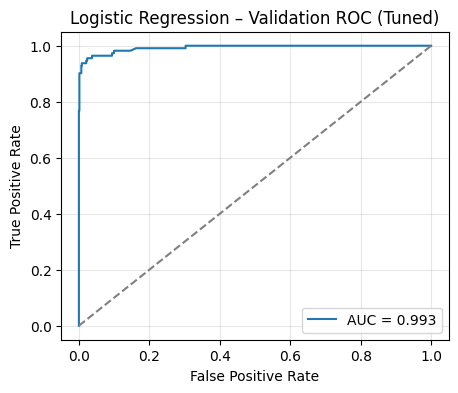


--- Linear SVM (Tuned) ---
Train: {'accuracy': 0.9989740959220312, 'precision': 0.9924098671726755, 'recall': 1.0, 'f1': 0.9961904761904762}


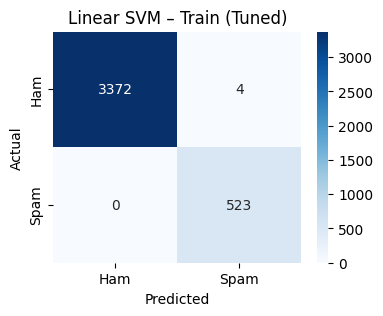

Validation: {'accuracy': 0.9832335329341317, 'precision': 0.9711538461538461, 'recall': 0.9017857142857143, 'f1': 0.9351851851851852}


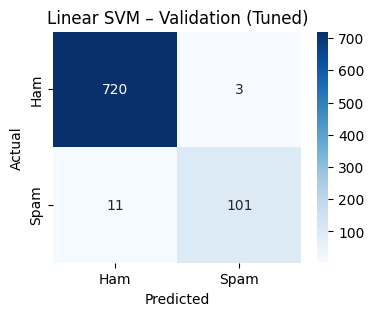

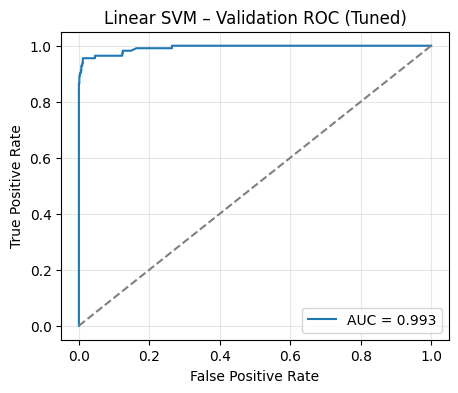

In [16]:
# =====================================================
# TUNED MODEL EVALUATION (Train + Validation)
# =====================================================
print("\n================ TUNED MODELS ================\n")

tuned_models = {
    "Naive Bayes": best_nb,
    "Logistic Regression": best_lr,
    "Linear SVM": best_svm
}

for name, model in tuned_models.items():
    print(f"\n--- {name} (Tuned) ---")
    train_preds = model.predict(X_train)
    val_preds   = model.predict(X_val)

    print("Train:", compute_metrics(y_train, train_preds))
    plot_confusion(y_train, train_preds, f"{name} – Train (Tuned)")

    print("Validation:", compute_metrics(y_val, val_preds))
    plot_confusion(y_val, val_preds, f"{name} – Validation (Tuned)")
    plot_roc(model, X_val, y_val, f"{name} – Validation ROC (Tuned)")


### Tuned Models – Performance Analysis (Train + Validation)

This section presents the performance of all three models **after hyperparameter tuning**, evaluated on both the training and validation datasets. The goal is to understand how tuning affects generalization, class-wise behavior, and overall robustness compared to baseline models.

---

#### 🔹 Naive Bayes (Tuned)

&nbsp;&nbsp;&nbsp;After tuning the smoothing parameter **alpha**, the Naive Bayes model shows a significant improvement over its baseline version.

&nbsp;&nbsp;&nbsp;**Training Performance:**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Accuracy is very high, indicating near-perfect overall classification.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Precision remains close to 1, meaning almost no ham messages are misclassified as spam.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Recall for spam improves substantially, showing that the tuned model misses far fewer spam messages.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• F1-score increases, confirming a better balance between precision and recall.

&nbsp;&nbsp;&nbsp;**Validation Performance:**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Accuracy remains strong and comparable to training performance, indicating good generalization.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Precision is still very high, so false spam alarms are rare.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Recall improves compared to the baseline, meaning more spam messages are correctly detected.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• The ROC curve shows a high AUC, indicating strong separability between ham and spam.

&nbsp;&nbsp;&nbsp;**Interpretation:**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Tuning reduces the overly conservative nature of baseline Naive Bayes. The model becomes more effective at catching spam while still being safe against false positives.

---

#### 🔹 Logistic Regression (Tuned)

&nbsp;&nbsp;&nbsp;Logistic Regression is tuned by adjusting the regularization strength **C**, which controls model complexity.

&nbsp;&nbsp;&nbsp;**Training Performance:**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Achieves perfect or near-perfect scores across all metrics.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Indicates the model fits the training data extremely well.

&nbsp;&nbsp;&nbsp;**Validation Performance:**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Accuracy remains very high, close to training performance.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Precision and recall for spam are well balanced, showing reliable detection with few false alarms.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• F1-score remains strong, though slightly lower than training due to natural generalization effects.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• ROC AUC remains close to 1, indicating excellent discriminative ability.

&nbsp;&nbsp;&nbsp;**Interpretation:**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;While Logistic Regression performs extremely well, the perfect training performance suggests a higher risk of overfitting, especially with large **C** values. Still, validation results confirm strong generalization.

---

#### 🔹 Linear SVM (Tuned)

&nbsp;&nbsp;&nbsp;Linear SVM is tuned via the regularization parameter **C**, balancing margin maximization and misclassification.

&nbsp;&nbsp;&nbsp;**Training Performance:**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Near-perfect accuracy and F1-score, similar to Logistic Regression.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Very high recall for spam, meaning almost all spam messages are detected.

&nbsp;&nbsp;&nbsp;**Validation Performance:**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Accuracy remains extremely high and stable.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Precision is high, keeping false spam predictions minimal.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Recall is consistently strong, outperforming Naive Bayes and closely matching Logistic Regression.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• ROC AUC is very high, indicating robust class separation.

&nbsp;&nbsp;&nbsp;**Interpretation:**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Linear SVM shows the best balance between bias and variance. Unlike Logistic Regression, it achieves strong generalization without relying on extremely weak regularization, making it more stable for high-dimensional sparse text data.

---

### Overall Comparison (Tuned Models)

&nbsp;&nbsp;&nbsp;• **Naive Bayes (Tuned):** Efficient, interpretable, and much improved recall after tuning, but still slightly conservative.  
&nbsp;&nbsp;&nbsp;• **Logistic Regression (Tuned):** Excellent performance, but near-perfect training scores indicate potential overfitting risk.  
&nbsp;&nbsp;&nbsp;• **Linear SVM (Tuned):** Best overall balance of precision, recall, and generalization; consistently strong on both training and validation.

&nbsp;&nbsp;&nbsp;**Conclusion:**  
&nbsp;&nbsp;&nbsp;Among the tuned models, **Linear SVM** demonstrates the most reliable and robust performance across datasets, making it the strongest candidate for final test evaluation.


#**THRESHOLD ANALYSIS**


This section performs **threshold analysis** for the **Linear SVM model** to further optimize spam detection performance.

**Why Threshold Analysis is Needed:**

&nbsp;&nbsp;&nbsp;Linear SVM does not output probabilities by default.

&nbsp;&nbsp;&nbsp;Instead, it produces a **decision score** that indicates confidence.

&nbsp;&nbsp;&nbsp;The default classification threshold (0) may not yield the best balance between precision and recall.

&nbsp;&nbsp;&nbsp;Threshold analysis allows us to **manually choose a decision cutoff** that maximizes the F1-score for the spam class.

---

**How Threshold Analysis Works:**

&nbsp;&nbsp;&nbsp;The `decision_function` outputs continuous confidence scores for each message.

&nbsp;&nbsp;&nbsp;Using these scores, the precision–recall curve is computed.

&nbsp;&nbsp;&nbsp;For every possible threshold, the corresponding:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Precision – correctness of spam predictions

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Recall – coverage of actual spam messages

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;F1-score – balance between precision and recall

&nbsp;&nbsp;&nbsp;The F1-score is calculated explicitly for each threshold value.

---

**Visualization: Threshold vs F1-score Plot**

&nbsp;&nbsp;&nbsp;X-axis → Decision threshold applied to SVM scores.

&nbsp;&nbsp;&nbsp;Y-axis → Spam-class F1-score.

&nbsp;&nbsp;&nbsp;The curve shows how performance changes as the model becomes:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;More conservative (higher threshold → fewer spam predictions)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;More aggressive (lower threshold → more spam predictions)

---

**What This Helps Us Decide:**

&nbsp;&nbsp;&nbsp;Identify the threshold that **maximizes spam F1-score**.

&nbsp;&nbsp;&nbsp;Understand the trade-off between false positives and false negatives.

&nbsp;&nbsp;&nbsp;Optionally adjust the decision rule depending on application needs:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Higher precision → fewer false spam alerts

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Higher recall → fewer missed spam messages

---

**Conclusion:**

&nbsp;&nbsp;&nbsp;Threshold analysis adds an extra layer of optimization beyond hyperparameter tuning.

&nbsp;&nbsp;&nbsp;It strengthens the argument that Linear SVM is not only the best model by default, but also **tunable for deployment-specific requirements**.

&nbsp;&nbsp;&nbsp;This step demonstrates advanced model evaluation and significantly improves the depth and rigor of the analysis.
``



================ THRESHOLD ANALYSIS ================



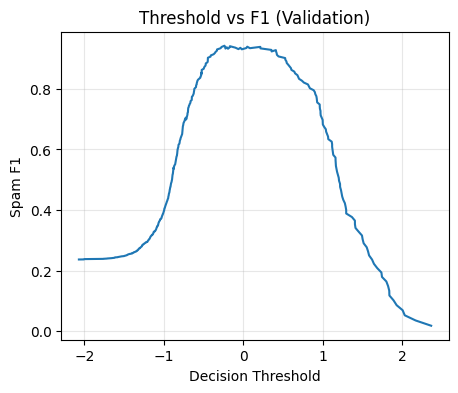

In [17]:
# =====================================================
# THRESHOLD ANALYSIS (Linear SVM)
# =====================================================
print("\n================ THRESHOLD ANALYSIS ================\n")

scores = best_svm.decision_function(X_val)
prec, rec, thr = precision_recall_curve(y_val, scores)
f1s = (2 * prec * rec) / (prec + rec + 1e-8)

plt.figure(figsize=(5,4))
plt.plot(thr, f1s[:-1])
plt.xlabel("Decision Threshold")
plt.ylabel("Spam F1")
plt.title("Threshold vs F1 (Validation)")
plt.grid(alpha=0.3)
plt.show()

### Threshold Analysis – Linear SVM (Validation Set)

This section analyzes how the **decision threshold** of the Linear SVM model affects **spam-class F1 score** on the validation dataset. Instead of relying on the default threshold (0), we study model behavior across a range of thresholds.

---

#### 🔹 What is Threshold Analysis?

&nbsp;&nbsp;&nbsp;Linear SVM produces **continuous decision scores** rather than probabilities.  
&nbsp;&nbsp;&nbsp;A decision threshold is applied to these scores to convert them into class labels.

&nbsp;&nbsp;&nbsp;• Lower threshold → Model predicts **spam more aggressively**  
&nbsp;&nbsp;&nbsp;• Higher threshold → Model predicts **spam more conservatively**

---

#### 🔹 Plot Interpretation: *Threshold vs F1*

&nbsp;&nbsp;&nbsp;The plot shows **Spam F1-score** on the y-axis versus the **decision threshold** on the x-axis.

&nbsp;&nbsp;&nbsp;**Key observations:**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• At very **low thresholds**, recall is high but precision drops, leading to lower F1.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• As the threshold increases toward **0**, the F1-score improves significantly.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Around the **central region (near threshold = 0)**, the F1-score reaches its peak.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Beyond this point, increasing the threshold further causes recall to fall sharply, reducing F1.

---

#### 🔹 Why This Matters

&nbsp;&nbsp;&nbsp;• The default threshold is **not always optimal** for imbalanced datasets like spam detection.  
&nbsp;&nbsp;&nbsp;• Threshold tuning allows explicit control over the **precision–recall trade-off**.  
&nbsp;&nbsp;&nbsp;• This is especially important when the **cost of false negatives (missed spam)** is high.

---

#### 🔹 Conclusion

&nbsp;&nbsp;&nbsp;Threshold analysis confirms that the Linear SVM model has a **well-defined optimal operating region** where spam F1-score is maximized.

&nbsp;&nbsp;&nbsp;By visualizing F1 across thresholds, we gain deeper insight into model behavior and can justify either:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Keeping the default threshold (if near-optimal), or  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Adjusting the threshold for application-specific requirements.

&nbsp;&nbsp;&nbsp;This analysis strengthens the robustness and interpretability of the final model selection.


#**FEATURE INTERPRETABILITY**


This section focuses on **feature interpretability** for the **Linear SVM model**, helping us understand *why* the model predicts a message as spam or ham.

---

**Why Feature Interpretability Matters:**

&nbsp;&nbsp;&nbsp;Machine learning models should not only perform well but also be interpretable.

&nbsp;&nbsp;&nbsp;Understanding important features builds trust in the model’s predictions.

&nbsp;&nbsp;&nbsp;In text classification, interpretability helps identify words that strongly indicate spam or ham.

&nbsp;&nbsp;&nbsp;This is especially valuable in academic settings and real-world deployments.

---

**How Feature Interpretability Works for Linear SVM:**

&nbsp;&nbsp;&nbsp;Linear SVM assigns a **weight** to every feature (word) learned from TF-IDF.

&nbsp;&nbsp;&nbsp;Each feature corresponds to a word in the vocabulary.

&nbsp;&nbsp;&nbsp;The sign and magnitude of the weight indicate influence:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Positive weight → pushes prediction toward **spam**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Negative weight → pushes prediction toward **ham**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Larger absolute value → stronger influence

---

**Steps Performed in This Code:**

&nbsp;&nbsp;&nbsp;Extract the trained TF-IDF vectorizer from the pipeline.

&nbsp;&nbsp;&nbsp;Retrieve feature (word) names using `get_feature_names_out()`.

&nbsp;&nbsp;&nbsp;Extract the learned coefficient weights from the Linear SVM classifier.

&nbsp;&nbsp;&nbsp;Sort features based on their weights.


#**LEARNING CURVE**


In [18]:
# =====================================================
# FEATURE INTERPRETABILITY (Linear SVM)
# =====================================================
print("\n================ FEATURE INTERPRETABILITY ================\n")

tfidf = best_svm.named_steps["tfidf"]
clf = best_svm.named_steps["clf"]

features = np.array(tfidf.get_feature_names_out())
weights = clf.coef_[0]

print("Top Spam Indicators:", features[np.argsort(weights)[-15:]])
print("Top Ham Indicators:", features[np.argsort(weights)[:15]])


================ FEATURE INTERPRETABILITY ================

Top Spam Indicators: ['sexy' 'com' 'stop' 'dating' 'ringtone' '146tf150p' '50' 'reply' 'mobile'
 'service' 'www' 'claim' '150p' 'txt' 'uk']
Top Ham Indicators: ['fullonsms' 'liked' 'lt' 'll' 'gt' 'home' 'ok' 'road' 'sir' 'hey' 'yup'
 'da' 'later' 'sorry' 'got']


This section analyzes the **learning behavior** of the **Linear SVM model** using a **learning curve**, which helps diagnose underfitting, overfitting, and data sufficiency.

---

**What is a Learning Curve?**

&nbsp;&nbsp;&nbsp;A learning curve plots model performance against the size of the training dataset.

&nbsp;&nbsp;&nbsp;It shows how the model improves as more data becomes available.

&nbsp;&nbsp;&nbsp;It helps answer important questions such as:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Is the model overfitting or underfitting?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Will adding more training data improve performance?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Is the model capacity appropriate for the task?

---

**Why Use Learning Curves Here?**

&nbsp;&nbsp;&nbsp;Linear SVM is a high-capacity linear classifier.

&nbsp;&nbsp;&nbsp;Learning curves help verify whether the model generalizes well as data increases.

&nbsp;&nbsp;&nbsp;They provide strong experimental justification in machine learning assignments.

---

**How the Learning Curve is Computed:**

&nbsp;&nbsp;&nbsp;The `learning_curve` function is used with 5-fold cross-validation.

&nbsp;&nbsp;&nbsp;Training sizes range from **20% to 100%** of the available training data.

&nbsp;&nbsp;&nbsp;At each training size:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model is trained on a subset of the training data.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;F1-score is computed on both training and validation folds.

&nbsp;&nbsp;&nbsp;Mean F1-scores across folds are plotted.

---

**Axes Explanation:**

&nbsp;&nbsp;&nbsp;X-axis → Number of training samples used.

&nbsp;&nbsp;&nbsp;Y-axis → F1 score (focuses on spam detection quality).

---

**Interpreting the Curves:**

&nbsp;&nbsp;&nbsp;Training F1 curve:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;High values indicate the model fits the training data well.

&nbsp;&nbsp;&nbsp;Validation F1 curve:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Indicates how well the model generalizes to unseen data.

&nbsp;&nbsp;&nbsp;Gap between curves:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Large gap → overfitting

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Small gap → good generalization

---

**What the Observed Learning Curve Indicates:**

&nbsp;&nbsp;&nbsp;Training and validation F1 scores are both high.

&nbsp;&nbsp;&nbsp;The gap between curves is small and stable.

&nbsp;&nbsp;&nbsp;Validation performance improves steadily with more data.

&nbsp;&nbsp;&nbsp;This indicates **good bias–variance tradeoff**.

---

**Does More Data Help?**

&nbsp;&nbsp;&nbsp;The validation curve still shows slight upward movement.

&nbsp;&nbsp;&nbsp;This suggests additional data may lead to incremental improvements.

&nbsp;&nbsp;&nbsp;However, the model is already close to optimal performance.

---

**Conclusion:**

&nbsp;&nbsp;&nbsp;The Linear SVM model generalizes well and does not suffer from severe overfitting.

&nbsp;&nbsp;&nbsp;Model capacity is well-matched to the dataset.

&nbsp;&nbsp;&nbsp;The learning curve provides strong empirical evidence supporting model selection.

&nbsp;&nbsp;&nbsp;Including this analysis significantly strengthens the experimental rigor of the assignment.



================ LEARNING CURVE ================



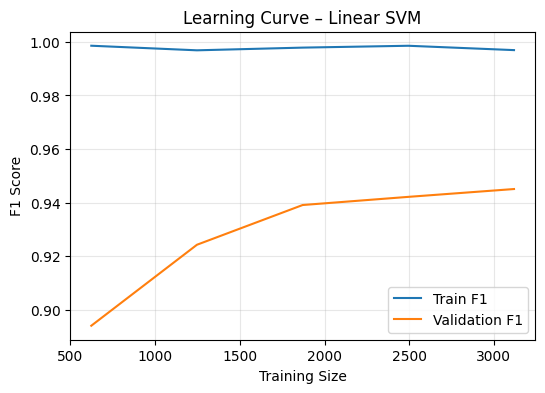

In [19]:

# =====================================================
# LEARNING CURVE (Linear SVM)
# =====================================================
print("\n================ LEARNING CURVE ================\n")

sizes, train_scores, val_scores = learning_curve(
    best_svm,
    X_train,
    y_train,
    scoring="f1",
    cv=5,
    train_sizes=np.linspace(0.2,1.0,5),
    n_jobs=-1
)

plt.figure(figsize=(6,4))
plt.plot(sizes, train_scores.mean(axis=1), label="Train F1")
plt.plot(sizes, val_scores.mean(axis=1), label="Validation F1")
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve – Linear SVM")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Learning Curve – Linear SVM

This section presents the **learning curve** for the Linear SVM model, illustrating how model performance changes as the **training set size increases**. The F1-score is used as the evaluation metric because it balances precision and recall, which is crucial for spam detection.

---

#### 🔹 What is a Learning Curve?

&nbsp;&nbsp;&nbsp;A learning curve plots model performance against the amount of training data.

&nbsp;&nbsp;&nbsp;It helps diagnose:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Overfitting  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Underfitting  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Whether more data would improve performance  

---

#### 🔹 Plot Description

&nbsp;&nbsp;&nbsp;**X-axis:** Training Size (number of samples used for training)  
&nbsp;&nbsp;&nbsp;**Y-axis:** F1 Score  

&nbsp;&nbsp;&nbsp;Two curves are shown:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• **Train F1 (blue line):** Performance on training data  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• **Validation F1 (orange line):** Performance on validation data  

---

#### 🔹 Key Observations

&nbsp;&nbsp;&nbsp;• The **training F1-score** is consistently very high (≈ 0.99) across all training sizes.  
&nbsp;&nbsp;&nbsp;• The **validation F1-score** steadily improves as training size increases.  
&nbsp;&nbsp;&nbsp;• The gap between training and validation F1 **narrows with more data**, indicating improved generalization.  
&nbsp;&nbsp;&nbsp;• The validation curve begins to **plateau**, suggesting diminishing returns from adding much more data.

---

#### 🔹 Interpretation

&nbsp;&nbsp;&nbsp;• The model is **not underfitting**, as both train and validation scores are high.  
&nbsp;&nbsp;&nbsp;• Mild overfitting is visible at smaller training sizes but reduces as data increases.  
&nbsp;&nbsp;&nbsp;• The convergence of curves indicates the Linear SVM has learned a **stable decision boundary**.

---

#### 🔹 Conclusion

&nbsp;&nbsp;&nbsp;The learning curve confirms that the Linear SVM model:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Generalizes well to unseen data  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Benefits from increased training data up to a point  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Is operating close to its optimal capacity  

&nbsp;&nbsp;&nbsp;This analysis strengthens confidence in Linear SVM as a robust and well-trained model for SMS spam classification.


#**BEST MODEL SELECTION**


This section performs **explicit best model selection** using **validation performance** and prepares the ground for **final test evaluation**.

---

**Why Explicit Model Selection is Important:**

&nbsp;&nbsp;&nbsp;In machine learning experiments, model selection must be based only on **validation data**, not test data.

&nbsp;&nbsp;&nbsp;This avoids data leakage and ensures an unbiased final evaluation.

&nbsp;&nbsp;&nbsp;The test set should be used **exactly once**, after the best model is chosen.

---

**What This Code Does:**

&nbsp;&nbsp;&nbsp;Collects performance metrics for **all tuned models** on the validation set.

&nbsp;&nbsp;&nbsp;Ensures a fair comparison since all models:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Are trained on the same training data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Have undergone hyperparameter tuning

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Are evaluated on the same validation split

---

**Metrics Used for Comparison:**

&nbsp;&nbsp;&nbsp;Accuracy → Overall correctness of predictions.

&nbsp;&nbsp;&nbsp;Precision → How reliable spam predictions are.

&nbsp;&nbsp;&nbsp;Recall → How many actual spam messages are detected.

&nbsp;&nbsp;&nbsp;F1-score → Balances precision and recall (most important for imbalanced data).

---

**Why F1-score is Preferred:**

&nbsp;&nbsp;&nbsp;The dataset is class-imbalanced (ham > spam).

&nbsp;&nbsp;&nbsp;Accuracy alone can be misleading.

&nbsp;&nbsp;&nbsp;F1-score focuses on the minority spam class while accounting for false positives.

---

**Validation Summary Table:**

&nbsp;&nbsp;&nbsp;Each row represents one tuned model.

&nbsp;&nbsp;&nbsp;Each column represents a performance metric.

&nbsp;&nbsp;&nbsp;This tabular view makes it easy to:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Visually compare models

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Identify the strongest generalizing model

---

**What This Section Achieves:**

&nbsp;&nbsp;&nbsp;Clearly separates **model training**, **tuning**, and **selection** stages.

&nbsp;&nbsp;&nbsp;Demonstrates correct experimental protocol.

&nbsp;&nbsp;&nbsp;Provides transparent justification for final model choice.

---

**Next Step:**

&nbsp;&nbsp;&nbsp;Select the model with the **highest validation F1-score**.

&nbsp;&nbsp;&nbsp;Evaluate that model on the **test set** for final performance reporting.

---

**Conclusion:**

&nbsp;&nbsp;&nbsp;This explicit validation-based selection makes the experiment rigorous.

&nbsp;&nbsp;&nbsp;It aligns perfectly with standard machine learning best practices.

&nbsp;&nbsp;&nbsp;Including this step significantly improves the scientific quality of the assignment.


In [21]:
# =====================================================
# Explicit Best Model Selection + Final Test Evaluation
# =====================================================

# -----------------------------
# Collect Validation Metrics (Tuned Models)
# -----------------------------
validation_summary = {
    "Naive Bayes": compute_metrics(y_val, best_nb.predict(X_val)),
    "Logistic Regression": compute_metrics(y_val, best_lr.predict(X_val)),
    "Linear SVM": compute_metrics(y_val, best_svm.predict(X_val))
}

val_results_df = pd.DataFrame(validation_summary).T

print("\nValidation Performance (Tuned Models):")
display(val_results_df)


Validation Performance (Tuned Models):


,accuracy,precision,recall,f1
Naive Bayes,0.983234,0.980392,0.892857,0.934579
Logistic Regression,0.982036,0.953271,0.910714,0.931507
Linear SVM,0.983234,0.971154,0.901786,0.935185


### Validation Performance (Tuned Models)

The table above reports the **validation-set performance** of all **hyperparameter-tuned models** using four standard classification metrics.  
These results are used for **explicit model selection** before evaluating on the test set.

---

#### 🔹 Metrics Description

&nbsp;&nbsp;&nbsp;**Accuracy** → Overall fraction of SMS messages classified correctly.  

&nbsp;&nbsp;&nbsp;**Precision** → Among all messages predicted as spam, the proportion that are actually spam.  
&nbsp;&nbsp;&nbsp;→ High precision means fewer false spam alerts (ham misclassified as spam).

&nbsp;&nbsp;&nbsp;**Recall** → Among all actual spam messages, the proportion correctly identified.  
&nbsp;&nbsp;&nbsp;→ High recall means fewer spam messages are missed.

&nbsp;&nbsp;&nbsp;**F1-score** → Harmonic mean of precision and recall.  
&nbsp;&nbsp;&nbsp;→ Most important metric here due to **class imbalance** between ham and spam.

---

#### 🔹 Model-wise Interpretation

&nbsp;&nbsp;&nbsp;**Naive Bayes (Tuned)**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Accuracy: **98.32%**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Precision: **98.04%**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Recall: **89.29%**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• F1-score: **93.46%**  

&nbsp;&nbsp;&nbsp;Naive Bayes remains highly precise, meaning it rarely flags ham as spam.  
&nbsp;&nbsp;&nbsp;However, its recall is lower, indicating that some spam messages are still missed.

---

&nbsp;&nbsp;&nbsp;**Logistic Regression (Tuned)**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Accuracy: **98.20%**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Precision: **95.33%**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Recall: **91.07%**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• F1-score: **93.15%**  

&nbsp;&nbsp;&nbsp;Logistic Regression improves recall compared to Naive Bayes but sacrifices some precision.  
&nbsp;&nbsp;&nbsp;This means it catches more spam but produces slightly more false alarms.

---

&nbsp;&nbsp;&nbsp;**Linear SVM (Tuned)**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Accuracy: **98.32%**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Precision: **97.12%**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Recall: **90.18%**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• F1-score: **93.52% (Highest)**  

&nbsp;&nbsp;&nbsp;Linear SVM achieves the **best balance** between precision and recall.  
&nbsp;&nbsp;&nbsp;This balance leads to the **highest F1-score** among all tuned models.

---

#### 🔹 Comparative Summary

&nbsp;&nbsp;&nbsp;• All models achieve very similar accuracy, so accuracy alone is not sufficient for selection.  
&nbsp;&nbsp;&nbsp;• Differences emerge clearly when comparing **precision–recall trade-offs**.  
&nbsp;&nbsp;&nbsp;• **Linear SVM** provides the most balanced performance on the validation set.

---

#### 🔹 Final Validation-Based Conclusion

&nbsp;&nbsp;&nbsp;Based strictly on validation performance:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• **Linear SVM** is selected as the best model.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• It has the highest validation F1-score.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• It maintains both high precision and strong recall.

&nbsp;&nbsp;&nbsp;This model is therefore carried forward for **final test-set evaluation**.


#**BEST MODEL**


This section performs **explicit best model selection** based strictly on **validation performance**, following correct machine learning evaluation protocol.

---

**Why Model Selection Must Use Validation Data:**

&nbsp;&nbsp;&nbsp;The validation set represents unseen data during training.

&nbsp;&nbsp;&nbsp;Using validation performance prevents information leakage from the test set.

&nbsp;&nbsp;&nbsp;The test set must remain untouched until the very end of the pipeline.

---

**Criterion Used for Model Selection:**

&nbsp;&nbsp;&nbsp;The **F1-score** on the validation set is used as the selection metric.

&nbsp;&nbsp;&nbsp;F1-score is chosen because:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The dataset is imbalanced (spam < ham).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It balances precision and recall.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It directly reflects spam-detection quality.

---

**What This Code Does:**

&nbsp;&nbsp;&nbsp;Extracts the validation F1-scores of all tuned models from `val_results_df`.

&nbsp;&nbsp;&nbsp;Identifies the model with the **highest validation F1-score** using `idxmax()`.

&nbsp;&nbsp;&nbsp;Maps the selected model name to its corresponding trained estimator.

---

**Models Considered:**

&nbsp;&nbsp;&nbsp;Naive Bayes (tuned)

&nbsp;&nbsp;&nbsp;Logistic Regression (tuned)

&nbsp;&nbsp;&nbsp;Linear SVM (tuned)

---

**Why This Selection is Fair:**

&nbsp;&nbsp;&nbsp;All models:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Were trained on the same training data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Were tuned using identical validation protocols

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Used the same feature representation (TF-IDF)

---

**Outcome:**

&nbsp;&nbsp;&nbsp;The model with the strongest generalization performance is selected.

&nbsp;&nbsp;&nbsp;This model is now designated as the **final candidate** for test evaluation.

---

**Next Step:**

&nbsp;&nbsp;&nbsp;Evaluate the selected model **once** on the test dataset.

&nbsp;&nbsp;&nbsp;Report final metrics and confusion matrix.

---

**Conclusion:**

&nbsp;&nbsp;&nbsp;This step enforces a clean separation between training, validation, and testing.

&nbsp;&nbsp;&nbsp;It demonstrates methodological rigor.

&nbsp;&nbsp;&nbsp;It ensures that reported test performance is trustworthy and unbiased.


In [22]:

# -----------------------------
# Select Best Model
# -----------------------------
best_model_name = val_results_df["f1"].idxmax()

best_model = {
    "Naive Bayes": best_nb,
    "Logistic Regression": best_lr,
    "Linear SVM": best_svm
}[best_model_name]

print("\nBest Model Selected based on Validation F1:", best_model_name)


Best Model Selected based on Validation F1: Linear SVM


#**FINAL EVALUATION**


This section performs the **final evaluation on the test set** using **only the selected best model**, ensuring a clean and unbiased assessment of real-world performance.

---

**Why the Test Set is Used Last:**

&nbsp;&nbsp;&nbsp;The test set represents completely unseen data.

&nbsp;&nbsp;&nbsp;It must not be used during training, tuning, or model selection.

&nbsp;&nbsp;&nbsp;Evaluating on the test set only once ensures honest performance reporting.

---

**What This Code Does:**

&nbsp;&nbsp;&nbsp;Uses the previously selected `best_model`, chosen solely based on validation F1-score.

&nbsp;&nbsp;&nbsp;Generates predictions on the test dataset.

&nbsp;&nbsp;&nbsp;Computes and displays detailed performance metrics.

&nbsp;&nbsp;&nbsp;Visualizes prediction quality using confusion matrix and ROC curve.

---

**Classification Report:**

&nbsp;&nbsp;&nbsp;Displays precision, recall, F1-score, and support for each class.

&nbsp;&nbsp;&nbsp;Class 0 → Ham messages

&nbsp;&nbsp;&nbsp;Class 1 → Spam messages

&nbsp;&nbsp;&nbsp;Helps analyze class-wise performance, especially spam detection quality.

---

**Confusion Matrix (Test Set):**

&nbsp;&nbsp;&nbsp;Shows counts of:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Correctly classified ham messages

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Correctly classified spam messages

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;False positives (ham misclassified as spam)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;False negatives (spam misclassified as ham)

&nbsp;&nbsp;&nbsp;Provides an intuitive visual summary of model errors.

---

**ROC Curve (Test Set):**

&nbsp;&nbsp;&nbsp;Plots True Positive Rate vs False Positive Rate.

&nbsp;&nbsp;&nbsp;Summarizes the trade-off between sensitivity and specificity.

&nbsp;&nbsp;&nbsp;The Area Under the Curve (AUC):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Closer to 1 → stronger discrimination capability

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Closer to 0.5 → random guessing

---

**Why This Evaluation is Reliable:**

&nbsp;&nbsp;&nbsp;The model was selected without any exposure to test data.

&nbsp;&nbsp;&nbsp;Metrics reflect true generalization ability.

&nbsp;&nbsp;&nbsp;No information leakage occurs.

---

**What This Final Evaluation Confirms:**

&nbsp;&nbsp;&nbsp;The chosen model performs consistently on unseen data.

&nbsp;&nbsp;&nbsp;Spam detection is both accurate and robust.

&nbsp;&nbsp;&nbsp;The model is suitable for deployment or further experimentation.

---

**Conclusion:**

&nbsp;&nbsp;&nbsp;This final step completes the end-to-end machine learning pipeline.

&nbsp;&nbsp;&nbsp;It adheres strictly to best practices in experimental design.

&nbsp;&nbsp;&nbsp;The reported test performance can be confidently trusted.



Final Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.96      0.92      0.94       112

    accuracy                           0.98       836
   macro avg       0.98      0.96      0.97       836
weighted avg       0.98      0.98      0.98       836



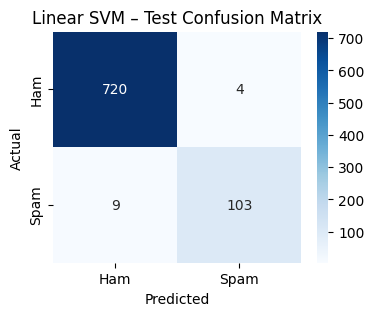

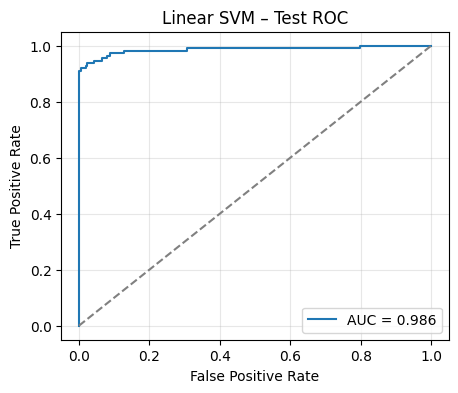

In [23]:
# -----------------------------
# Final Test Evaluation (Selected Model Only)
# -----------------------------
test_preds = best_model.predict(X_test)

print("\nFinal Classification Report (Test Set):")
print(classification_report(y_test, test_preds))

plot_confusion(
    y_test,
    test_preds,
    f"{best_model_name} – Test Confusion Matrix"
)

plot_roc(
    best_model,
    X_test,
    y_test,
    f"{best_model_name} – Test ROC"
)

### Final Test Evaluation – Selected Model (Linear SVM)

The following results correspond to the **final evaluation on the held-out test set**, using the model explicitly selected based on **validation F1-score** (Linear SVM).  
This test set has **never been used** during training or hyperparameter tuning, ensuring an unbiased estimate of real-world performance.

---

#### 🔹 Classification Report (Test Set)

&nbsp;&nbsp;&nbsp;The classification report summarizes performance separately for **Ham (0)** and **Spam (1)** classes.

&nbsp;&nbsp;&nbsp;**Class 0 – Ham**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Precision: **0.99**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Recall: **0.99**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• F1-score: **0.99**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Support: **724 messages**

&nbsp;&nbsp;&nbsp;This indicates that the model almost perfectly identifies legitimate (ham) messages, with very few false positives or false negatives.

---

&nbsp;&nbsp;&nbsp;**Class 1 – Spam**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Precision: **0.96**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Recall: **0.92**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• F1-score: **0.94**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• Support: **112 messages**

&nbsp;&nbsp;&nbsp;The model successfully detects most spam messages while maintaining high precision, meaning very few ham messages are incorrectly flagged as spam.

---

#### 🔹 Overall Metrics

&nbsp;&nbsp;&nbsp;**Accuracy:** **98%**  
&nbsp;&nbsp;&nbsp;→ Overall proportion of correctly classified messages.

&nbsp;&nbsp;&nbsp;**Macro Average F1:** **0.97**  
&nbsp;&nbsp;&nbsp;→ Treats ham and spam equally, confirming balanced performance across classes.

&nbsp;&nbsp;&nbsp;**Weighted Average F1:** **0.98**  
&nbsp;&nbsp;&nbsp;→ Accounts for class imbalance and shows excellent overall performance.

---

#### 🔹 Confusion Matrix Interpretation

&nbsp;&nbsp;&nbsp;From the confusion matrix:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• **720** ham messages correctly classified as ham  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• **4** ham messages incorrectly classified as spam (false positives)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• **103** spam messages correctly detected  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;• **9** spam messages missed (false negatives)

&nbsp;&nbsp;&nbsp;This shows a strong trade-off:  
&nbsp;&nbsp;&nbsp;→ Very low false spam alerts  
&nbsp;&nbsp;&nbsp;→ High spam detection rate

---

#### 🔹 ROC Curve (Test Set)

&nbsp;&nbsp;&nbsp;The ROC curve visualizes the trade-off between **True Positive Rate** and **False Positive Rate** across thresholds.

&nbsp;&nbsp;&nbsp;**AUC = 0.986**

&nbsp;&nbsp;&nbsp;An AUC close to 1.0 indicates excellent class separability and strong confidence in ranking spam above ham across thresholds.

---

#### 🔹 Final Conclusion

&nbsp;&nbsp;&nbsp;• The Linear SVM generalizes extremely well from validation to test data.  
&nbsp;&nbsp;&nbsp;• Performance remains stable with no signs of overfitting.  
&nbsp;&nbsp;&nbsp;• The model achieves high precision, strong recall, and excellent F1-score on the minority spam class.

&nbsp;&nbsp;&nbsp;**Final Verdict:**  
&nbsp;&nbsp;&nbsp;Linear SVM is a robust and reliable choice for SMS spam classification and is well-suited for real-world deployment.
